In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/widsdatathon2025/SAMPLE_SUBMISSION.xlsx
/kaggle/input/widsdatathon2025/Data Dictionary.xlsx
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAINING_SOLUTIONS.xlsx
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_CATEGORICAL_METADATA.xlsx
/kaggle/input/widsdatathon2025/TRAIN_OLD/TRAIN_QUANTITATIVE_METADATA.xlsx
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx
/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx
/kaggle/input/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv
/kaggle/input/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx
/kaggle/input/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx


In [2]:
import os
import json
import numpy as np
import pandas as pd

import seaborn as sns
import math

# Model building
import sklearn #has tools for ML and statistical modeling
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier #ML Algorithm for classification and regression

from scipy.io import loadmat

# Utility
import matplotlib.pyplot as plt

# Warnings
import warnings
warnings.filterwarnings("ignore")
print("packages imported")

packages imported


In [3]:
# === Load TRAIN data ===
train_path = "/kaggle/input/widsdatathon2025/TRAIN_NEW"
connectome_train = pd.read_csv(f"{train_path}/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
quant_meta_train = pd.read_excel(f"{train_path}/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
cat_meta_train = pd.read_excel(f"{train_path}/TRAIN_CATEGORICAL_METADATA_new.xlsx")
targets_train = pd.read_excel(f"{train_path}/TRAINING_SOLUTIONS.xlsx")

# Check shapes
print("Connectome:", connectome_train.shape)
print("Quantitative metadata:", quant_meta_train.shape)
print("Categorical metadata:", cat_meta_train.shape)
print("Targets:", targets_train.shape)

Connectome: (1213, 19901)
Quantitative metadata: (1213, 19)
Categorical metadata: (1213, 10)
Targets: (1213, 3)


In [4]:
# === Load TEST data ===
test_path = "/kaggle/input/widsdatathon2025/TEST"
connectome_test = pd.read_csv(f"{test_path}/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")
quant_meta_test = pd.read_excel(f"{test_path}/TEST_QUANTITATIVE_METADATA.xlsx")
cat_meta_test = pd.read_excel(f"{test_path}/TEST_CATEGORICAL.xlsx")

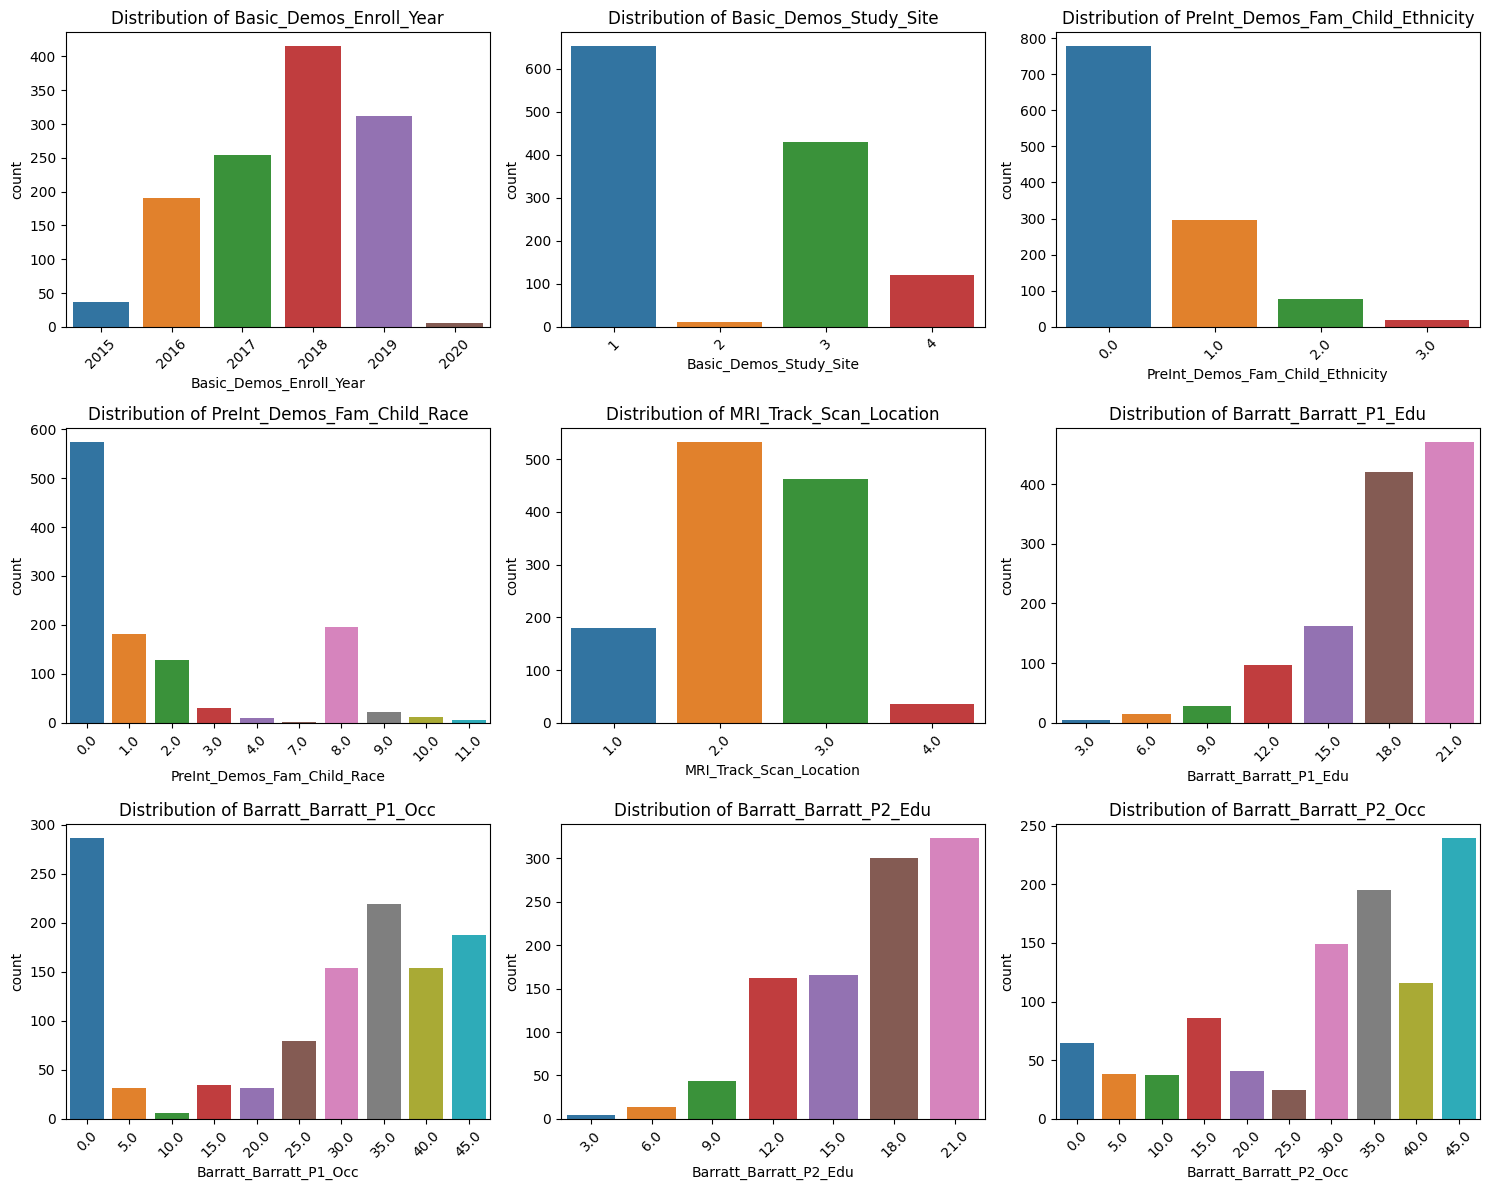

In [5]:
# Drop participant_id
demo_cols = cat_meta_train.columns.drop('participant_id')

# Define number of plots
n_cols = 3  # Number of columns in subplot grid
n_plots = len(demo_cols)
n_rows = math.ceil(n_plots / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Flatten to index easily

# Plot each variable
for i, col in enumerate(demo_cols):
    sns.countplot(x=col, data=cat_meta_train, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel(col)

# Turn off unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

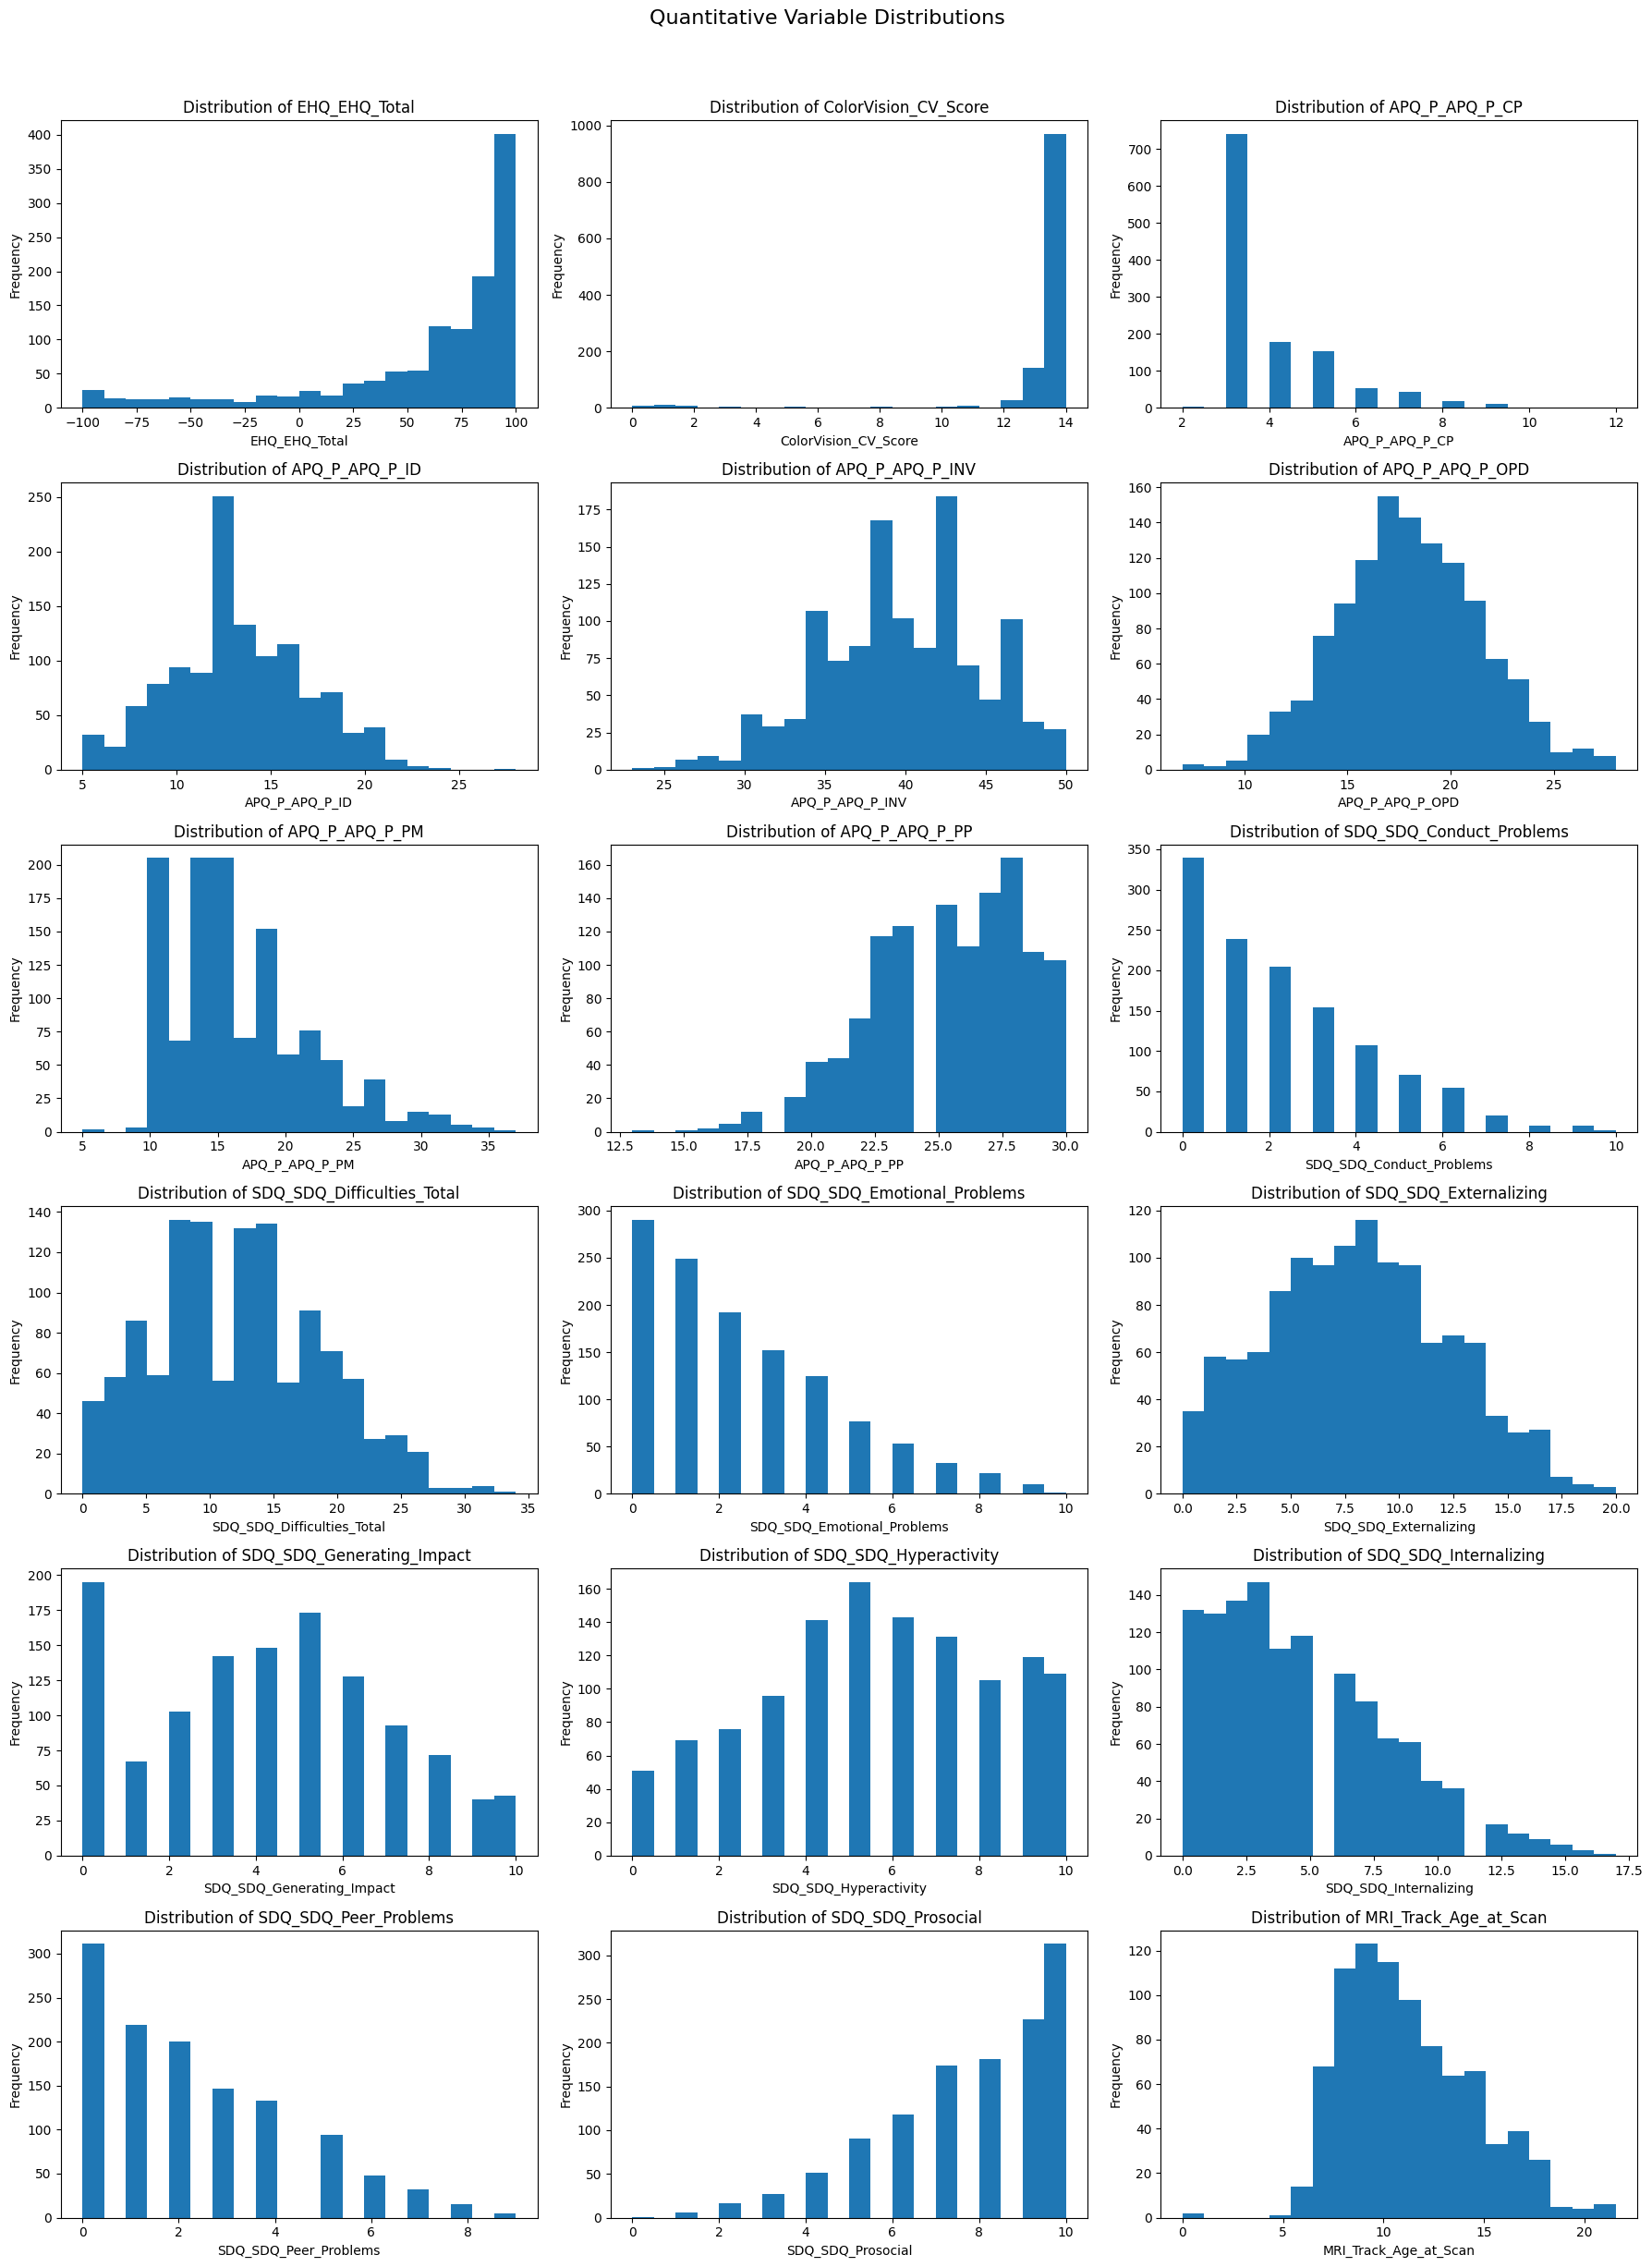

In [6]:
# Drop 'participant_id'
quant_cols = quant_meta_train.columns.drop('participant_id')

# Subplot grid configuration
n_cols = 3
n_plots = len(quant_cols)
n_rows = math.ceil(n_plots / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Flatten axes to iterate easily

# Plot each histogram
for i, col in enumerate(quant_cols):
    quant_meta_train[col].plot.hist(bins=20, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Turn off unused axes (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Quantitative Variable Distributions", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

ADHD_Outcome
1    831
0    382
Name: count, dtype: int64


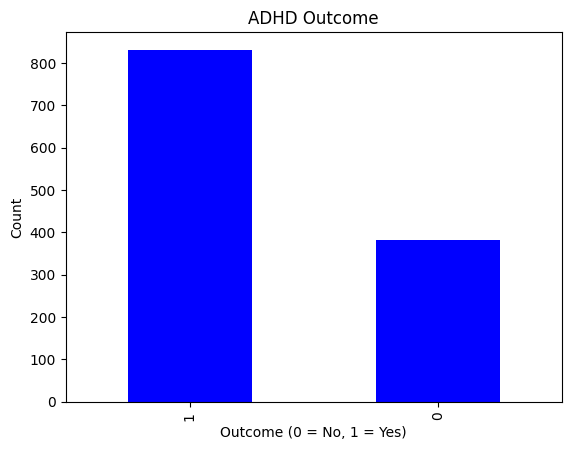

Sex_F
0    797
1    416
Name: count, dtype: int64


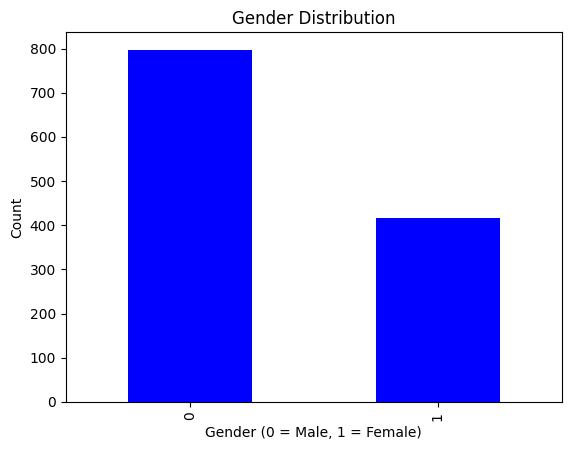

In [7]:
print(targets_train['ADHD_Outcome'].value_counts())
targets_train['ADHD_Outcome'].value_counts().plot(kind='bar', color='blue')
plt.title('ADHD Outcome')
plt.xlabel('Outcome (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Gender distribution
print(targets_train['Sex_F'].value_counts())
targets_train['Sex_F'].value_counts().plot(kind='bar', color='blue')
plt.title('Gender Distribution')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Count')
plt.show()

There is a clear class bias.


In [8]:
for col in cat_meta_train.select_dtypes(include='int').columns:
    cat_meta_train[col] = cat_meta_train[col].astype('category')
    
# Creating a list of all of the columns except the first
columns_to_encode = cat_meta_train.columns[1:].tolist()

# Print the columns to encode
print("Columns to encode:", columns_to_encode)
# encoding categorical data
train_encoded = pd.get_dummies(cat_meta_train[columns_to_encode], drop_first=True)
train_encoded = train_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))
# Combine encoded columns with the rest of the DataFrame
cat_train_final = pd.concat([cat_meta_train.drop(columns=columns_to_encode), train_encoded], axis=1)

# Make sure it looks correct
cat_train_final.head()

Columns to encode: ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ']


,participant_id,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4
0,00aIpNTbG5uh,1.0,0.0,3.0,21.0,45.0,NaN,NaN,0,0,0,1,0,0,0,1
1,00fV0OyyoLfw,0.0,9.0,2.0,21.0,0.0,21.0,45.0,0,1,0,0,0,0,0,0
2,04X1eiS79T4B,1.0,2.0,2.0,9.0,0.0,NaN,NaN,0,1,0,0,0,0,0,0
3,05ocQutkURd6,3.0,8.0,2.0,18.0,10.0,18.0,0.0,0,0,1,0,0,0,0,0
4,06YUNBA9ZRLq,0.0,1.0,2.0,12.0,0.0,NaN,NaN,0,0,1,0,0,0,0,0


In [9]:
# convert our int variables to categories
for col in cat_meta_test.select_dtypes(include='int').columns:
    cat_meta_test[col] = cat_meta_test[col].astype('category')

# Encode categorical variables in test
test_encoded = pd.get_dummies(cat_meta_test[columns_to_encode], drop_first=True)
test_encoded = test_encoded.map(lambda x: 1 if x is True else (0 if x is False else x))

# Ensure test_encoded has the same columns as train_encoded
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0  # Add missing columns with 0 values

# Ensure test_encoded columns are in the same order as train_encoded
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

# Combine encoded columns with the rest of the DataFrame
cat_test_final = pd.concat([cat_meta_test.drop(columns=columns_to_encode), test_encoded], axis=1)

cat_test_final.head()

,participant_id,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3,Basic_Demos_Study_Site_4
0,Cfwaf5FX7jWK,0.0,0.0,0,21.0,30.0,18.0,30.0,0,0,0,0,0,0,0,0
1,vhGrzmvA3Hjq,0.0,0.0,0,21.0,45.0,NaN,30.0,0,0,0,0,0,0,0,0
2,ULliyEXjy4OV,0.0,0.0,0,21.0,40.0,18.0,40.0,0,0,0,0,0,0,0,0
3,LZfeAb1xMtql,0.0,0.0,0,21.0,45.0,21.0,45.0,0,0,0,0,0,0,0,0
4,EnFOUv0YK1RG,2.0,0.0,0,18.0,0.0,21.0,45.0,0,0,0,0,0,0,0,0


In [10]:
cat_train_final['For']='Training'
cat_test_final['For']='Testing'

combine_cat_df=pd.concat([cat_train_final, cat_test_final], ignore_index=True)
print("number of null values")
print(combine_cat_df.isna().sum())
print(combine_cat_df.isna().sum().sum())
combine_cat_imp_df=combine_cat_df

number of null values
participant_id                        0
PreInt_Demos_Fam_Child_Ethnicity     46
PreInt_Demos_Fam_Child_Race          60
MRI_Track_Scan_Location               3
Barratt_Barratt_P1_Edu               16
Barratt_Barratt_P1_Occ               32
Barratt_Barratt_P2_Edu              234
Barratt_Barratt_P2_Occ              264
Basic_Demos_Enroll_Year_2016          0
Basic_Demos_Enroll_Year_2017          0
Basic_Demos_Enroll_Year_2018          0
Basic_Demos_Enroll_Year_2019          0
Basic_Demos_Enroll_Year_2020          0
Basic_Demos_Study_Site_2              0
Basic_Demos_Study_Site_3              0
Basic_Demos_Study_Site_4              0
For                                   0
dtype: int64
655


In [11]:
# Replace null values with the mean of the column for training data
for col in combine_cat_imp_df.columns:
    if combine_cat_imp_df[col].isna().sum() > 0:  # Check if the column has NaN values
        combine_cat_imp_df[col] = combine_cat_imp_df[col].fillna(combine_cat_imp_df[col].mode()[0]) 


print(combine_cat_imp_df.isna().sum().sum())

0


In [12]:
# Split back into train and test sets based on 'For' column
cat_train_data = combine_cat_imp_df[combine_cat_imp_df['For'] == 'Training'].drop('For', axis=1)
cat_test_data = combine_cat_imp_df[combine_cat_imp_df['For'] == 'Testing'].drop('For', axis=1)

# Verify the split
print("Training set shape:", cat_train_data.shape)
print("Test set shape:", cat_test_data.shape)

# Verify that we have all data
total_rows = len(combine_cat_imp_df)
split_rows = len(cat_train_data) + len(cat_test_data)
print("\nTotal rows in combined data:", total_rows)
print("Total rows after splitting:", split_rows)
print("All rows accounted for:", total_rows == split_rows)

Training set shape: (1213, 16)
Test set shape: (304, 16)

Total rows in combined data: 1517
Total rows after splitting: 1517
All rows accounted for: True


In [13]:
quant_meta_train['For']='Training'
quant_meta_test['For']='Testing'
combine_quant_df=pd.concat([quant_meta_train, quant_meta_test], ignore_index=True)
print("number of null values")
print(combine_quant_df.isna().sum())
print(combine_quant_df.isna().sum().sum())

combine_quant_imp_df=combine_quant_df

number of null values
participant_id                  0
EHQ_EHQ_Total                  14
ColorVision_CV_Score           32
APQ_P_APQ_P_CP                 27
APQ_P_APQ_P_ID                 27
APQ_P_APQ_P_INV                27
APQ_P_APQ_P_OPD                27
APQ_P_APQ_P_PM                 27
APQ_P_APQ_P_PP                 27
SDQ_SDQ_Conduct_Problems       39
SDQ_SDQ_Difficulties_Total     39
SDQ_SDQ_Emotional_Problems     39
SDQ_SDQ_Externalizing          39
SDQ_SDQ_Generating_Impact      39
SDQ_SDQ_Hyperactivity          39
SDQ_SDQ_Internalizing          39
SDQ_SDQ_Peer_Problems          39
SDQ_SDQ_Prosocial              39
MRI_Track_Age_at_Scan         360
For                             0
dtype: int64
919


In [14]:
for col in combine_quant_imp_df.columns:
    if combine_quant_imp_df[col].isna().sum() > 0:
        mean = combine_quant_imp_df[col].mean()
        std = combine_quant_imp_df[col].std()
        n_missing = combine_quant_imp_df[col].isna().sum()
        
        # Sample from Gaussian distribution for missing entries
        sampled_values = np.random.normal(loc=mean, scale=std, size=n_missing)
        
        # Assign sampled values to NaNs
        combine_quant_imp_df.loc[combine_quant_imp_df[col].isna(), col] = sampled_values

# Confirm no NaNs remain
print(combine_quant_imp_df.isna().sum().sum())

0


In [15]:
# Split back into train and test sets based on 'For' column
quant_train_data = combine_quant_imp_df[combine_quant_imp_df['For'] == 'Training'].drop('For', axis=1)
quant_test_data = combine_quant_imp_df[combine_quant_imp_df['For'] == 'Testing'].drop('For', axis=1)

# Verify the split
print("Training set shape:", quant_train_data.shape)
print("Test set shape:", quant_test_data.shape)

# Verify that we have all data
total_rows = len(combine_quant_imp_df)
split_rows = len(quant_train_data) + len(quant_test_data)
print("\nTotal rows in combined data:", total_rows)
print("Total rows after splitting:", split_rows)
print("All rows accounted for:", total_rows == split_rows)

Training set shape: (1213, 19)
Test set shape: (304, 19)

Total rows in combined data: 1517
Total rows after splitting: 1517
All rows accounted for: True


In [16]:
train_df = pd.merge(cat_train_data, quant_train_data, on = 'participant_id') #default
train_target_df = pd.merge(train_df, targets_train, on = 'participant_id') #default
train_target_Conn_df= pd.merge(train_target_df,  connectome_train, on = 'participant_id') #default
train_target_Conn_df.head()

,participant_id,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,00aIpNTbG5uh,1.0,0.0,3.0,21.0,45.0,21.0,45.0,0,0,...,-0.047477,-0.096450,-0.280312,0.037560,0.423037,0.242453,0.336213,0.402338,0.327915,0.539032
1,00fV0OyyoLfw,0.0,9.0,2.0,21.0,0.0,21.0,45.0,0,1,...,-0.143218,-0.276464,-0.332783,-0.332711,0.556939,0.475578,0.429196,0.457970,0.312571,0.595978
2,04X1eiS79T4B,1.0,2.0,2.0,9.0,0.0,21.0,45.0,0,1,...,-0.133778,-0.108588,-0.002132,-0.175586,0.679183,0.290292,0.486680,0.255208,0.575017,0.605182
3,05ocQutkURd6,3.0,8.0,2.0,18.0,10.0,18.0,0.0,0,0,...,-0.096647,-0.041420,-0.199576,-0.216457,0.519074,0.298586,0.415466,0.511607,0.361204,0.446613
4,06YUNBA9ZRLq,0.0,1.0,2.0,12.0,0.0,21.0,45.0,0,0,...,-0.158995,-0.274017,-0.141012,-0.002865,0.515169,0.336139,0.316430,0.442230,0.177079,0.378278


In [17]:
test_df = pd.merge(cat_test_data, quant_test_data, on = 'participant_id')
test_Conn_df = pd.merge(test_df, connectome_test, on = 'participant_id')

test_Conn_df.head()

,participant_id,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,Cfwaf5FX7jWK,0.0,0.0,0.0,21.0,30.0,18.0,30.0,0,0,...,0.080423,-0.054581,-0.088163,-0.028574,0.444847,0.350149,-0.012601,0.665750,0.560565,0.555732
1,vhGrzmvA3Hjq,0.0,0.0,0.0,21.0,45.0,21.0,30.0,0,0,...,0.198009,-0.000724,0.083122,0.033043,0.687497,0.306229,0.717485,0.461809,0.559632,0.350027
2,ULliyEXjy4OV,0.0,0.0,0.0,21.0,40.0,18.0,40.0,0,0,...,0.051319,0.023630,-0.056819,0.117396,0.576086,0.517831,0.527044,0.605038,0.609856,0.750987
3,LZfeAb1xMtql,0.0,0.0,0.0,21.0,45.0,21.0,45.0,0,0,...,0.046183,-0.238962,0.121868,-0.260970,0.646818,0.594902,0.608156,0.595459,0.683189,0.542296
4,EnFOUv0YK1RG,2.0,0.0,0.0,18.0,0.0,21.0,45.0,0,0,...,0.315734,0.002234,0.290791,0.344149,0.480214,0.539824,0.447322,0.293088,0.148529,0.539823


In [18]:
X_train = train_target_Conn_df.drop(columns = ['participant_id', 'ADHD_Outcome', 'Sex_F'])


Y_train = targets_train.drop(columns = ['participant_id'])

In [19]:
X_train2 = train_target_df.drop(columns = ['participant_id', 'ADHD_Outcome', 'Sex_F'])


Y_train2 = targets_train.drop(columns = ['participant_id'])

In [20]:
!pip install iterative-stratification

In [21]:
from sklearn.metrics import f1_score, classification_report
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import joblib

# Use all numeric features
adhd_features2 = X_train2.select_dtypes(include=[np.number]).columns.tolist()
sexf_features2 = adhd_features2.copy()

best_f1_2 = -1
best_adhd_model2 = None
best_sex_model2 = None
f1_scores2 = []

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(mskf.split(X_train2, Y_train2)):
    print(f"\n--- Fold {fold+1} ---")
    X_tr, X_val = X_train.iloc[train_idx], X_train2.iloc[val_idx]
    Y_tr, Y_val = Y_train.iloc[train_idx], Y_train2.iloc[val_idx]
    
    # Optional: keep only numeric columns in case of mixed dtypes
    X_tr = X_tr[adhd_features2]
    X_val = X_val[adhd_features2]

    spw_adhd = (Y_tr['ADHD_Outcome'] == 0).sum() / (Y_tr['ADHD_Outcome'] == 1).sum()
    spw_sex = (Y_tr['Sex_F'] == 0).sum() / (Y_tr['Sex_F'] == 1).sum()

    xgb_adhd = XGBClassifier(scale_pos_weight=spw_adhd, objective='binary:logistic',
                             n_estimators=100, learning_rate=0.01, max_depth=3,
                             subsample=0.5, use_label_encoder=False, eval_metric='logloss')

    xgb_sex = XGBClassifier(scale_pos_weight=spw_sex, objective='binary:logistic',
                            n_estimators=100, learning_rate=0.01, max_depth=3,
                            subsample=0.5, use_label_encoder=False, eval_metric='logloss')

    xgb_adhd.fit(X_tr, Y_tr['ADHD_Outcome'])
    xgb_sex.fit(X_tr, Y_tr['Sex_F'])

    adhd_pred = xgb_adhd.predict(X_val)
    sex_pred = xgb_sex.predict(X_val)
    Y_pred = np.vstack([adhd_pred, sex_pred]).T

    f1 = f1_score(Y_val, Y_pred, average='macro')
    f1_scores2.append(f1)

    print(f"Macro F1 score: {f1:.4f}")
    print(classification_report(Y_val, Y_pred, target_names=['ADHD_Outcome', 'Sex_F']))

    if f1 > best_f1_2:
        best_f1_2 = f1
        best_adhd_model2 = xgb_adhd
        best_sex_model2 = xgb_sex
        X_val_best2 = X_val.copy()  # <-- Save validation features for SHAP
        Y_val_best2 = Y_val.copy()  # <-- Optional: Save validation labels too


# Save models
#joblib.dump(best_adhd_model2, 'best_adhd_model2.pkl')
#joblib.dump(best_sex_model2, 'best_sex_model2.pkl')

# Save F1 scores
#pd.Series(f1_scores2).to_csv('f1_scores.csv', index_label='Fold', header=['Macro_F1'])

# Feature importance diagnostics
adhd_importances2 = pd.Series(best_adhd_model2.feature_importances_, index=adhd_features2).sort_values(ascending=False)
sexf_importances2 = pd.Series(best_sex_model2.feature_importances_, index=sexf_features2).sort_values(ascending=False)

# Save importance to CSV for further analysis
#adhd_importances2.to_csv('adhd_feature_importances2.csv')
#sexf_importances2.to_csv('sexf_feature_importances2.csv')

print("Mean F1 score across folds:", np.mean(f1_scores2))


--- Fold 1 ---
Macro F1 score: 0.5310
              precision    recall  f1-score   support

ADHD_Outcome       0.65      0.62      0.64       166
       Sex_F       0.39      0.47      0.43        83

   micro avg       0.55      0.57      0.56       249
   macro avg       0.52      0.55      0.53       249
weighted avg       0.56      0.57      0.57       249
 samples avg       0.44      0.48      0.43       249


--- Fold 2 ---
Macro F1 score: 0.5606
              precision    recall  f1-score   support

ADHD_Outcome       0.69      0.72      0.70       166
       Sex_F       0.34      0.53      0.42        83

   micro avg       0.54      0.65      0.59       249
   macro avg       0.52      0.62      0.56       249
weighted avg       0.58      0.65      0.61       249
 samples avg       0.49      0.54      0.49       249


--- Fold 3 ---
Macro F1 score: 0.4995
              precision    recall  f1-score   support

ADHD_Outcome       0.65      0.63      0.64       167
       Sex_F

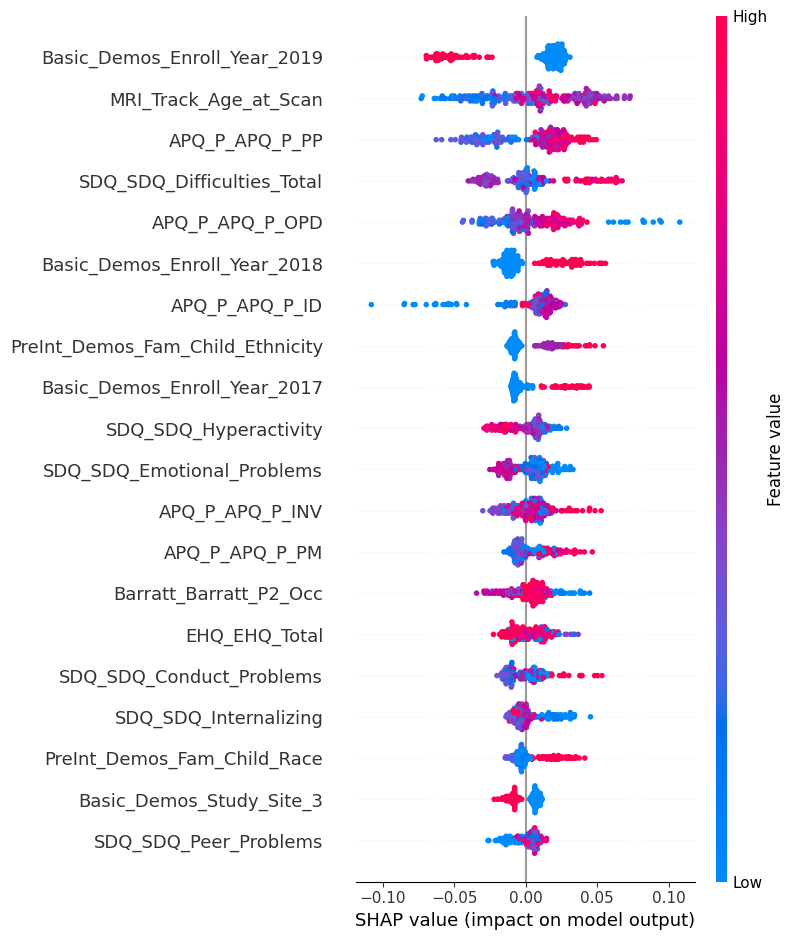

In [22]:
import shap

explainer_adhd = shap.TreeExplainer(best_adhd_model2)
shap_values_adhd = explainer_adhd.shap_values(X_val_best2)

explainer_sex = shap.TreeExplainer(best_sex_model2)
shap_values_sex = explainer_sex.shap_values(X_val_best2)

# Convert to DataFrames
shap_df_adhd = pd.DataFrame(shap_values_adhd, columns=adhd_features2)
shap_df_sex = pd.DataFrame(shap_values_sex, columns=sexf_features2)
shap.summary_plot(shap_values_adhd, X_val_best2)

In [23]:
shap_df_adhd.abs().mean().sort_values(ascending=False).head(10)

Basic_Demos_Enroll_Year_2019        0.029111
MRI_Track_Age_at_Scan               0.028291
APQ_P_APQ_P_PP                      0.023429
SDQ_SDQ_Difficulties_Total          0.019175
APQ_P_APQ_P_OPD                     0.018672
Basic_Demos_Enroll_Year_2018        0.017650
APQ_P_APQ_P_ID                      0.016333
PreInt_Demos_Fam_Child_Ethnicity    0.013169
Basic_Demos_Enroll_Year_2017        0.011715
SDQ_SDQ_Hyperactivity               0.011474
dtype: float32

In [24]:
shap_df_sex.abs().mean().sort_values(ascending=False).head(10)

APQ_P_APQ_P_PM                  0.051849
SDQ_SDQ_Difficulties_Total      0.034779
SDQ_SDQ_Hyperactivity           0.033223
SDQ_SDQ_Peer_Problems           0.029693
Basic_Demos_Enroll_Year_2018    0.022163
APQ_P_APQ_P_INV                 0.021925
EHQ_EHQ_Total                   0.020626
MRI_Track_Scan_Location         0.019709
SDQ_SDQ_Conduct_Problems        0.019669
APQ_P_APQ_P_ID                  0.018172
dtype: float32

In [25]:
sexf_low_shap_features = shap_df_sex.abs().mean()[shap_df_sex.abs().mean() < 0.005].index.tolist()

sexf_low_shap_features

['Basic_Demos_Enroll_Year_2016',
 'Basic_Demos_Enroll_Year_2017',
 'Basic_Demos_Enroll_Year_2019',
 'Basic_Demos_Enroll_Year_2020',
 'Basic_Demos_Study_Site_2',
 'Basic_Demos_Study_Site_4',
 'APQ_P_APQ_P_CP']

In [26]:
adhd_low_shap_features = shap_df_adhd.abs().mean()[shap_df_adhd.abs().mean() < 0.005].index.tolist()

adhd_low_shap_features

['Barratt_Barratt_P1_Occ',
 'Barratt_Barratt_P2_Edu',
 'Basic_Demos_Enroll_Year_2020',
 'Basic_Demos_Study_Site_2',
 'Basic_Demos_Study_Site_4',
 'ColorVision_CV_Score',
 'SDQ_SDQ_Externalizing']

In [27]:
adhd_low_imp_features = adhd_importances2[adhd_importances2 < 0.028].index.tolist()
print(adhd_low_imp_features)
sex_low_imp_features = sexf_importances2[sexf_importances2 < 0.025].index.tolist()
print(sex_low_imp_features)

['SDQ_SDQ_Prosocial', 'Barratt_Barratt_P2_Edu', 'Basic_Demos_Study_Site_2', 'Basic_Demos_Enroll_Year_2020']
['Basic_Demos_Enroll_Year_2016', 'Basic_Demos_Study_Site_2', 'Basic_Demos_Enroll_Year_2020']


In [28]:
adhd_high_imp_features_all_data = adhd_importances2[adhd_importances2 > 0.0005].index.tolist()
sexf_high_imp_features_all_data = sexf_importances2[sexf_importances2 > 0.0005].index.tolist() #0.0002

In [29]:
# Remove low-importance features
adhd_features3 = [f for f in X_train2.select_dtypes(include=[np.number]).columns if f not in adhd_low_imp_features]
sexf_features3 = [f for f in X_train2.select_dtypes(include=[np.number]).columns if f not in sex_low_imp_features]
#[f for f in adhd_features3 if f not in sex_low_imp_features]  # ensures both pruned

best_f1_3 = -1
best_adhd_model3 = None
best_sex_model3 = None
f1_scores3 = []

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(mskf.split(X_train2, Y_train2)):
    print(f"\n--- Fold {fold+1} ---")
    
    X_tr, X_val = X_train2.iloc[train_idx], X_train2.iloc[val_idx]
    Y_tr, Y_val = Y_train2.iloc[train_idx], Y_train2.iloc[val_idx]

    # Apply filtered features
    X_tr_adhd = X_tr[adhd_features3]
    X_val_adhd = X_val[adhd_features3]
    
    X_tr_sex = X_tr[sexf_features3]
    X_val_sex = X_val[sexf_features3]

    spw_adhd = (Y_tr['ADHD_Outcome'] == 0).sum() / (Y_tr['ADHD_Outcome'] == 1).sum()
    spw_sex = (Y_tr['Sex_F'] == 0).sum() / (Y_tr['Sex_F'] == 1).sum()

    xgb_adhd = XGBClassifier(scale_pos_weight=spw_adhd, objective='binary:logistic',
                             n_estimators=100, learning_rate=0.01, max_depth=3,
                             subsample=0.5, use_label_encoder=False, eval_metric='logloss')

    xgb_sex = XGBClassifier(scale_pos_weight=spw_sex, objective='binary:logistic',
                            n_estimators=100, learning_rate=0.01, max_depth=3,
                            subsample=0.5, use_label_encoder=False, eval_metric='logloss')

    xgb_adhd.fit(X_tr_adhd, Y_tr['ADHD_Outcome'])
    xgb_sex.fit(X_tr_sex, Y_tr['Sex_F'])

    adhd_pred = xgb_adhd.predict(X_val_adhd)
    sex_pred = xgb_sex.predict(X_val_sex)
    Y_pred = np.vstack([adhd_pred, sex_pred]).T

    f1 = f1_score(Y_val, Y_pred, average='macro')
    f1_scores3.append(f1)

    print(f"Macro F1 score: {f1:.4f}")
    print(classification_report(Y_val, Y_pred, target_names=['ADHD_Outcome', 'Sex_F']))

    if f1 > best_f1_3:
        best_f1_3 = f1
        best_adhd_model3 = xgb_adhd
        best_sex_model3 = xgb_sex

# Save models
#joblib.dump(best_adhd_model3, 'best_adhd_model3.pkl')
#joblib.dump(best_sex_model3, 'best_sex_model3.pkl')

# Save F1 scores
#pd.Series(f1_scores3).to_csv('f1_scores3.csv', index_label='Fold', header=['Macro_F1'])

# Feature importance diagnostics
adhd_importances3 = pd.Series(best_adhd_model3.feature_importances_, index=adhd_features3).sort_values(ascending=False)
sexf_importances3 = pd.Series(best_sex_model3.feature_importances_, index=sexf_features3).sort_values(ascending=False)

# Save importance to CSV for further analysis
#adhd_importances3.to_csv('adhd_feature_importances3.csv')
#sexf_importances3.to_csv('sexf_feature_importances3.csv')

print("Mean F1 score across folds:", np.mean(f1_scores3))


--- Fold 1 ---
Macro F1 score: 0.5256
              precision    recall  f1-score   support

ADHD_Outcome       0.65      0.60      0.63       166
       Sex_F       0.39      0.47      0.43        83

   micro avg       0.55      0.56      0.55       249
   macro avg       0.52      0.54      0.53       249
weighted avg       0.56      0.56      0.56       249
 samples avg       0.44      0.47      0.43       249


--- Fold 2 ---
Macro F1 score: 0.5663
              precision    recall  f1-score   support

ADHD_Outcome       0.69      0.72      0.70       166
       Sex_F       0.36      0.54      0.43        83

   micro avg       0.55      0.66      0.60       249
   macro avg       0.52      0.63      0.57       249
weighted avg       0.58      0.66      0.61       249
 samples avg       0.50      0.54      0.49       249


--- Fold 3 ---
Macro F1 score: 0.4818
              precision    recall  f1-score   support

ADHD_Outcome       0.65      0.60      0.62       167
       Sex_F

In [30]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

# Filter features based on importance (excluding low-importance ones)
adhd_features5 = [f for f in X_train.select_dtypes(include=[np.number]).columns if f not in sexf_low_shap_features]
sexf_features5 = [f for f in X_train.select_dtypes(include=[np.number]).columns if f not in adhd_low_shap_features]

# Initialize tracking variables
best_f1_5 = -1
best_adhd_model5 = None
best_sex_model5 = None
f1_scores5 = []

# Stratified k-fold setup
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(mskf.split(X_train, Y_train)):
    print(f"\n--- Fold {fold + 1} ---")

    # Split data
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    Y_tr, Y_val = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

    X_tr_adhd = X_tr[adhd_features5]
    X_val_adhd = X_val[adhd_features5]

    X_tr_sex = X_tr[sexf_features5]
    X_val_sex = X_val[sexf_features5]

    # Calculate class weights
    spw_adhd = (Y_tr['ADHD_Outcome'] == 0).sum() / (Y_tr['ADHD_Outcome'] == 1).sum()
    spw_sex = (Y_tr['Sex_F'] == 0).sum() / (Y_tr['Sex_F'] == 1).sum()

    # Train models
    xgb_adhd = XGBClassifier(
        scale_pos_weight=spw_adhd,
        objective='binary:logistic',
        n_estimators=100,
        learning_rate=0.01,
        max_depth=3,
        subsample=0.5,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    xgb_sex = XGBClassifier(
        scale_pos_weight=spw_sex,
        objective='binary:logistic',
        n_estimators=100,
        learning_rate=0.01,
        max_depth=3,
        subsample=0.5,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    xgb_adhd.fit(X_tr_adhd, Y_tr['ADHD_Outcome'])
    xgb_sex.fit(X_tr_sex, Y_tr['Sex_F'])

    # Make predictions
    adhd_pred = xgb_adhd.predict(X_val_adhd)
    sex_pred = xgb_sex.predict(X_val_sex)
    Y_pred = np.vstack([adhd_pred, sex_pred]).T

    # Evaluate performance
    f1 = f1_score(Y_val, Y_pred, average='macro')
    f1_scores5.append(f1)

    print(f"Macro F1 score: {f1:.4f}")
    print(classification_report(Y_val, Y_pred, target_names=['ADHD_Outcome', 'Sex_F']))

    # Save best model
    if f1 > best_f1_5:
        best_f1_5 = f1
        best_adhd_model5 = xgb_adhd
        best_sex_model5 = xgb_sex
        X_val_best5 = X_val.copy()
        Y_val_best5 = Y_val.copy()

# Save F1 scores
pd.Series(f1_scores5).to_csv('f1_scores5.csv', index_label='Fold', header=['Macro_F1'])

# Save feature importances
adhd_importances5 = pd.Series(best_adhd_model5.feature_importances_, index=adhd_features5).sort_values(ascending=False)
sexf_importances5 = pd.Series(best_sex_model5.feature_importances_, index=sexf_features5).sort_values(ascending=False)

adhd_importances5.to_csv('adhd_feature_importances5.csv')
sexf_importances5.to_csv('sexf_feature_importances5.csv')

print("Mean F1 score across folds:", np.mean(f1_scores5))



--- Fold 1 ---
Macro F1 score: 0.4280
              precision    recall  f1-score   support

ADHD_Outcome       0.69      0.86      0.77       166
       Sex_F       0.17      0.06      0.09        83

   micro avg       0.63      0.59      0.61       249
   macro avg       0.43      0.46      0.43       249
weighted avg       0.52      0.59      0.54       249
 samples avg       0.56      0.52      0.53       249


--- Fold 2 ---
Macro F1 score: 0.4515
              precision    recall  f1-score   support

ADHD_Outcome       0.68      0.87      0.76       166
       Sex_F       0.25      0.10      0.14        83

   micro avg       0.63      0.61      0.62       249
   macro avg       0.47      0.48      0.45       249
weighted avg       0.54      0.61      0.56       249
 samples avg       0.57      0.53      0.53       249


--- Fold 3 ---
Macro F1 score: 0.5330
              precision    recall  f1-score   support

ADHD_Outcome       0.69      0.85      0.76       167
       Sex_F

In [31]:
adhd_features6 = [f for f in X_train.select_dtypes(include=[np.number]).columns 
                  if f in adhd_high_imp_features_all_data and f not in sexf_low_shap_features]

sexf_features6 = [f for f in X_train.select_dtypes(include=[np.number]).columns 
                  if f in sexf_high_imp_features_all_data and f not in adhd_low_shap_features]


best_f1_6 = -1
best_adhd_model6 = None
best_sex_model6 = None
f1_scores6 = []



mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(mskf.split(X_train, Y_train)):
    print(f"\n--- Fold {fold+1} ---")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    Y_tr, Y_val = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

    # Apply filtered features
    X_tr_adhd = X_tr[adhd_features6]
    X_val_adhd = X_val[adhd_features6]
    
    X_tr_sex = X_tr[sexf_features6]
    X_val_sex = X_val[sexf_features6]

    spw_adhd = (Y_tr['ADHD_Outcome'] == 0).sum() / (Y_tr['ADHD_Outcome'] == 1).sum()
    spw_sex = 1.2*(Y_tr['Sex_F'] == 0).sum() / (Y_tr['Sex_F'] == 1).sum() #1.2 is better

    #defauls n_estimators=100, learning_rate=0.01, max_depth=3,subsample=0.5,

    xgb_adhd = XGBClassifier(scale_pos_weight=spw_adhd, objective='binary:logistic',
                             n_estimators=800, learning_rate=0.005, max_depth=5,
                             subsample=0.7, use_label_encoder=False, eval_metric='logloss',
                             colsample_bytree=0.7,
                             min_child_weight=2,
                             gamma=0.1
                             #reg_alpha=0.1 #didnt improve scores
                             )

    xgb_sex = XGBClassifier(scale_pos_weight=spw_sex, objective='binary:logistic',
                            n_estimators=400, learning_rate=0.01, max_depth=3,
                            subsample=0.7, use_label_encoder=False, eval_metric='logloss',
                            colsample_bytree=0.5,
                            min_child_weight=5,
                            gamma=0.2,
                            #reg_alpha=0.5 #didnt improve scores
                            #reg_lambda=2   #didnt improve scores
                            )

    xgb_adhd.fit(X_tr_adhd, Y_tr['ADHD_Outcome'])
    xgb_sex.fit(X_tr_sex, Y_tr['Sex_F'])

    adhd_pred = xgb_adhd.predict(X_val_adhd)
    sex_pred = xgb_sex.predict(X_val_sex)
    Y_pred = np.vstack([adhd_pred, sex_pred]).T

    f1 = f1_score(Y_val, Y_pred, average='macro')
    f1_scores6.append(f1)

    print(f"Macro F1 score: {f1:.4f}")
    print(classification_report(Y_val, Y_pred, target_names=['ADHD_Outcome', 'Sex_F']))

    if f1 > best_f1_6:
        best_f1_6 = f1
        best_adhd_model6 = xgb_adhd
        best_sex_model6 = xgb_sex
        X_val_best6 = X_val.copy()
        Y_val_best6 = Y_val.copy()

# Save models
#joblib.dump(best_adhd_model6, 'best_adhd_model6.pkl')
#joblib.dump(best_sex_model6, 'best_sex_model6.pkl')

# Save F1 scores
#pd.Series(f1_scores6).to_csv('f1_scores6.csv', index_label='Fold', header=['Macro_F1'])

# Feature importance diagnostics
adhd_importances6 = pd.Series(best_adhd_model6.feature_importances_, index=adhd_features6).sort_values(ascending=False)
sexf_importances6 = pd.Series(best_sex_model6.feature_importances_, index=sexf_features6).sort_values(ascending=False)

# Save importance to CSV for further analysis
#adhd_importances6.to_csv('adhd_feature_importances6.csv')
#sexf_importances6.to_csv('sexf_feature_importances6.csv')

print("Mean F1 score across folds:", np.mean(f1_scores6))


--- Fold 1 ---
Macro F1 score: 0.5531
              precision    recall  f1-score   support

ADHD_Outcome       0.65      0.67      0.66       166
       Sex_F       0.34      0.61      0.44        83

   micro avg       0.51      0.65      0.57       249
   macro avg       0.50      0.64      0.55       249
weighted avg       0.55      0.65      0.59       249
 samples avg       0.45      0.54      0.47       249


--- Fold 2 ---
Macro F1 score: 0.5861
              precision    recall  f1-score   support

ADHD_Outcome       0.69      0.75      0.72       166
       Sex_F       0.34      0.67      0.45        83

   micro avg       0.52      0.72      0.61       249
   macro avg       0.52      0.71      0.59       249
weighted avg       0.58      0.72      0.63       249
 samples avg       0.50      0.59      0.51       249


--- Fold 3 ---
Macro F1 score: 0.5377
              precision    recall  f1-score   support

ADHD_Outcome       0.67      0.66      0.66       167
       Sex_F

ELIMINATE FALSE POSTIVES


In [32]:
explainer_adhd6 = shap.TreeExplainer(best_adhd_model6)
shap_values_adhd6 = explainer_adhd6.shap_values(X_val_best6[adhd_features6])

explainer_sex6 = shap.TreeExplainer(best_sex_model6)
shap_values_sex6 = explainer_sex6.shap_values(X_val_best6[sexf_features6])

# Convert to DataFrames
shap_df_adhd6 = pd.DataFrame(shap_values_adhd6, columns=adhd_features6)
shap_df_sex6 = pd.DataFrame(shap_values_sex6, columns=sexf_features6)

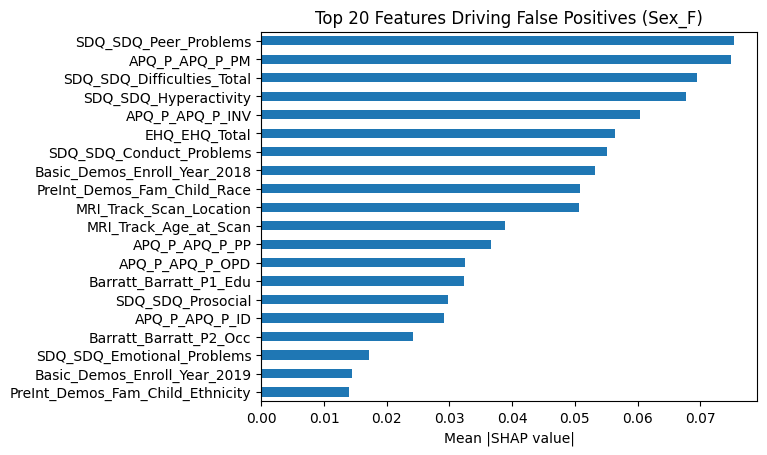

In [33]:
# Predict probabilities and classes
sex_probs_val6 = best_sex_model6.predict_proba(X_val_best6[sexf_features6])[:, 1]
sex_preds_val6 = (sex_probs_val6 > 0.5).astype(int)  # Using default 0.5 threshold
# True labels
true_labels = Y_val_best6['Sex_F'].values

# Find indices where model predicted 1 but true label was 0
false_positive_indices = np.where((sex_preds_val6 == 1) & (true_labels == 0))[0]
# SHAP values for just the false positives
shap_fp = shap_df_sex6.iloc[false_positive_indices]

# Original feature values for these FPs (optional)
X_fp = X_val_best6[sexf_features6].iloc[false_positive_indices]
# Mean absolute shap value per feature across false positives
shap_fp_mean = shap_fp.abs().mean().sort_values(ascending=False)
sexf_fp_shap20 =shap_fp_mean.head(20)
#print(sexf_fp_shap20)
sexf_fp_shap20.plot(kind='barh')
plt.title('Top 20 Features Driving False Positives (Sex_F)')
plt.xlabel('Mean |SHAP value|')
plt.gca().invert_yaxis()
plt.show()

In [34]:
# Full training data for ADHD
X_train_adhd_full = X_train[adhd_features6]
y_train_adhd_full = Y_train['ADHD_Outcome']

# Full training data for Sex_F
X_train_sex_full = X_train[sexf_features6]
y_train_sex_full = Y_train['Sex_F']

# Recreate models with same settings
#final_adhd_model6 = XGBClassifier(scale_pos_weight=(y_train_adhd_full == 0).sum() / (y_train_adhd_full == 1).sum(),
#                                  objective='binary:logistic',
#                                  n_estimators=100, learning_rate=0.01, max_depth=3,
#                                  subsample=0.5, use_label_encoder=False, eval_metric='logloss')


#final_sex_model6 = XGBClassifier(scale_pos_weight=1.2 * (y_train_sex_full == 0).sum() / (y_train_sex_full == 1).sum(),
#                                 objective='binary:logistic',
#                                 n_estimators=100, learning_rate=0.01, max_depth=3,
#                                 subsample=0.5, use_label_encoder=False, eval_metric='logloss')

final_adhd_model6 = XGBClassifier(scale_pos_weight=(y_train_adhd_full == 0).sum() / (y_train_adhd_full == 1).sum(),
                                  objective='binary:logistic',
                                  n_estimators=800, learning_rate=0.005, max_depth=5,
                                  subsample=0.7, use_label_encoder=False, eval_metric='logloss',
                                  #colsample_bytree=0.7,
                                  #min_child_weight=2,
                                  #gamma=0.1
                                  )


final_sex_model6 = XGBClassifier(scale_pos_weight=1.2* (y_train_sex_full == 0).sum() / (y_train_sex_full == 1).sum(),
                                 objective='binary:logistic',
                                 n_estimators=400, learning_rate=0.01, max_depth=3,
                                 subsample=0.7, use_label_encoder=False, eval_metric='logloss',
                                 #colsample_bytree=0.5,
                                 #min_child_weight=5,
                                 #gamma=0.2
                                 )

# Train on full training data
final_adhd_model6.fit(X_train_adhd_full, y_train_adhd_full);
final_sex_model6.fit(X_train_sex_full, y_train_sex_full);

In [35]:
X_test= test_Conn_df.drop(columns = ['participant_id'])
# Prepare test set (use same feature subsets!)
X_test_adhd = X_test[adhd_features6]
X_test_sex = X_test[sexf_features6]

# Predict
adhd_test_pred = final_adhd_model6.predict(X_test_adhd)
sex_test_pred = final_sex_model6.predict(X_test_sex)

# Combine into final prediction
final_test_pred = np.vstack([adhd_test_pred, sex_test_pred]).T

In [36]:
participant_id = test_Conn_df['participant_id']
# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(
   final_test_pred,
    columns=['Predicted_ADHD', 'Predicted_Gender']
)
# Combine participant IDs with predictions
result_df = pd.concat([participant_id.reset_index(drop=True), predictions_df], axis=1)
result_df

,participant_id,Predicted_ADHD,Predicted_Gender
0,Cfwaf5FX7jWK,0,1
1,vhGrzmvA3Hjq,1,1
2,ULliyEXjy4OV,0,1
3,LZfeAb1xMtql,0,1
4,EnFOUv0YK1RG,0,1
...,...,...,...
299,UadZfjdEg7eG,1,1
300,IUEHiLmQAqCi,1,0
301,cRySmCadYFRO,1,1
302,E3MvDUtJadc5,1,1


In [37]:
result_df.to_csv('submission_XGBOOST_Akilidada.csv', index=False) 
print("submission has been saved")

submission has been saved
